# Electricity Customer에 대해서 수행

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import random
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_forecasting.metrics import SMAPE,RMSE,MAE
from captum.attr import IntegratedGradients,NoiseTunnel

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def MSE(pred,target):
    return torch.mean((pred-target)**2,dim = 0) # reduction까지 취해줌

## 1. 모델 구성하기
* 시간단위의 데이터로써 24x30 =720 즉 30일을 바라봄

In [3]:
data = pd.read_csv('./GeneralData/ElectricityCustomer.csv')
sequence_length = 720
pred_len = 1

In [4]:
data = data.drop(columns='Unnamed: 0')

In [5]:
data = data[['customer10']]

In [6]:
data

,customer10
0,266.666667
1,277.419355
2,249.462366
3,226.881720
4,208.602151
...,...
8756,325.806452
8757,280.645161
8758,289.247312
8759,290.322581


<AxesSubplot: >

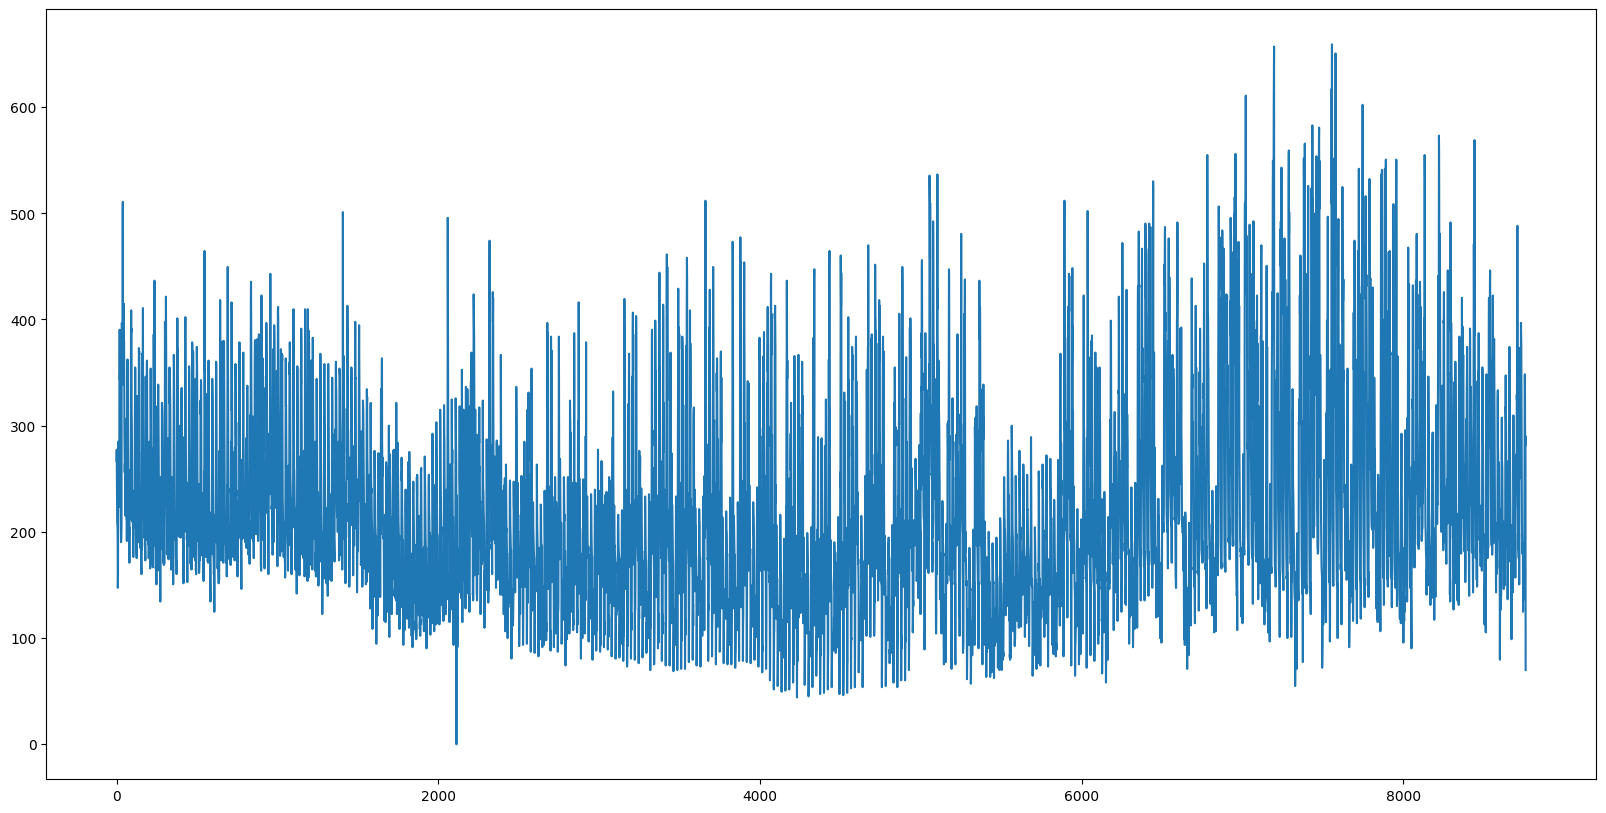

In [7]:
plt.figure(figsize=(20,10))
data['customer10'].plot()

In [8]:
from torch import FloatTensor as FloatTensor

In [9]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(len(x)-sequence_length):
        seq_list.append(x.iloc[i:i+sequence_length].values)
        target_list.append(x.iloc[i+sequence_length].values)

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [10]:
split = 24*7 # 24시간 x 7로써 1주일을 테스트셋으로 만듦

In [11]:
seed = 42

In [12]:
device = torch.device("cuda:0")

In [13]:
class Model(nn.Module):
    def __init__(self,train_index):
        super().__init__()
        self.seq_len = len(train_index)
        self.pred_len = 1
        self.train_index = train_index
        self.first_layer = nn.Linear(self.seq_len,self.pred_len)
        self.first_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
    def forward(self,x):
        return self.first_layer(x[:,:,self.train_index]) 

# 3. Train-Validation set으로 쪼개기

In [14]:
data

,customer10
0,266.666667
1,277.419355
2,249.462366
3,226.881720
4,208.602151
...,...
8756,325.806452
8757,280.645161
8758,289.247312
8759,290.322581


* 8761개 중 일주일치 데이터인 168개의 데이터를 Test Set
* 8761 중 0.2의 비율인 1752개는 validation set
* 8761개 중 0.8의 비율인 7009개는 train set

In [15]:
val_num = 1752

In [16]:
train = data.iloc[:-split-val_num]
val = data.iloc[-split-val_num:-split]
x_train,y_train = seq_data(train, sequence_length = sequence_length, pred_len = pred_len)
x_val,y_val = seq_data(val, sequence_length = sequence_length, pred_len = pred_len)
train_dataset = TensorDataset(x_train,y_train)
val_dataset = TensorDataset(x_val,y_val)
training = DataLoader(train_dataset,batch_size=64)
validation = DataLoader(val_dataset,batch_size=64)

/tmp/ipykernel_717517/2654461304.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [17]:
next(iter(validation))[0].size()

torch.Size([64, 1, 720])

### 위와 같은 방식으로 validation-set에 대해서 기여도를 구하면 될 것이다.
-> 모든 batch의 각 sample에 대해서 Ig를 통한 attribution을 구해서 모든 batch에 걸쳐서 더한후 그것을 평균시킨다.<br>
-> 결과적으로 모든 validation set에 대한 attribution을 평균한다.

In [18]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
train_index = np.arange(sequence_length)
model = Model(train_index).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
num_epochs = 100
n= len(training)

### 기본 모델 training

In [19]:
import copy

In [20]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
minimal_loss=np.inf
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
        
        outputs = outputs.view(-1,1)
        labels = labels.view(-1,1)
        
        # defining loss
        loss = MSE(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")

model = best_model

Epoch [1]/[100] running accumulative loss across all batches: 666140.788
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
Epoch [21]/[100] running accumulative loss across all batches: 265730.263
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
Epoch [41]/[100] running accumulative loss across all batches: 220022.210
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
Epoch [61]/[100] running accumulative loss across all batches: 197902.967
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
Epoch [81]/[100] running accumulative loss across all batches: 18

### validation set에 대해서 attribution 구하기

In [21]:
n = len(validation)
n

17

In [22]:
cnt = 0
ig = IntegratedGradients(model)
nt_ig = NoiseTunnel(ig)
nt_ig_attr_score = torch.zeros((1,sequence_length))
for val in validation:
    temp_n = val[0].size(0)
    temp = nt_ig.attribute(val[0]).sum(axis = 0) # axis=0으로 batch axis를 기준으로 다 더했음
    nt_ig_attr_score = nt_ig_attr_score.to(device)+temp
    cnt = cnt + temp_n
nt_ig_attr_score = nt_ig_attr_score/cnt
nt_ig_attr_score = nt_ig_attr_score.cpu().numpy().reshape(-1)

In [23]:
len(nt_ig_attr_score)

720

<AxesSubplot: >

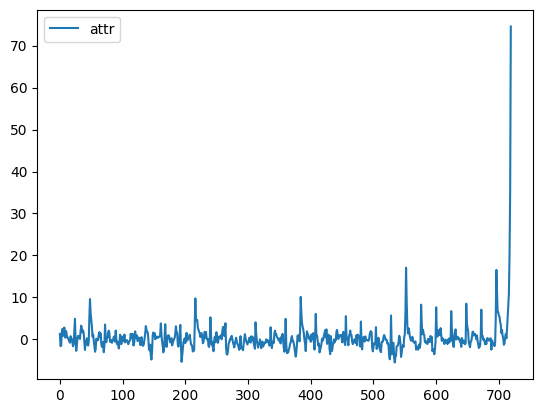

In [24]:
attr_df = pd.DataFrame({'attr':nt_ig_attr_score})
attr_df.plot()

### &rightarrow; 최근데이터가 매우강조 되는것을 확인할 수 있다.

#### scaling

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
attr_df = scaler.fit_transform(attr_df.values)
attr_df = pd.DataFrame({"attr":attr_df.reshape(-1)})
attr_df

,attr
0,0.236775
1,-0.509126
2,-0.479381
3,0.335360
4,0.545311
...,...
715,2.003992
716,2.733856
717,5.079333
718,9.067983


#### train_index구하기

In [26]:
index_list = []

for hyper_parameter in np.arange(0.01,1.01,0.01):
    append_idx = list(attr_df[(attr_df['attr']>hyper_parameter) | (attr_df['attr']<-hyper_parameter)].index)
    index_list.append(append_idx)
len(index_list) # train_index의 리스트

100

In [27]:
len_list=[]
for i in range(100):
    len_list.append(len(index_list[i]))


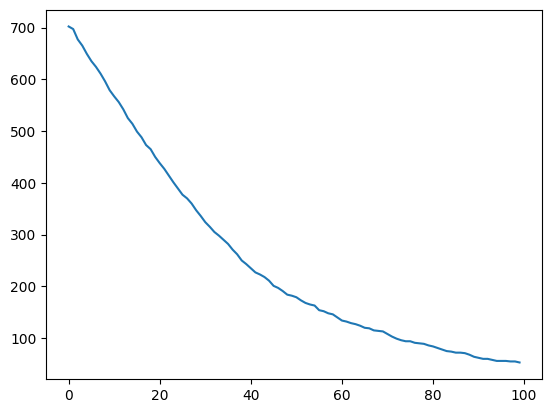

In [28]:
plt.plot(np.arange(100),len_list) # 포함되는 time_index의 갯수

In [29]:
for val_x,val_y in validation:
    print(val_x,val_y)

tensor([[[169.8925, 172.0430, 168.8172,  ..., 216.1290, 200.0000, 198.9247]],

        [[172.0430, 168.8172, 165.5914,  ..., 200.0000, 198.9247, 167.7419]],

        [[168.8172, 165.5914, 175.2688,  ..., 198.9247, 167.7419, 149.4624]],

        ...,

        [[374.1935, 415.0538, 422.5807,  ..., 354.8387, 513.9785, 524.7312]],

        [[415.0538, 422.5807, 320.4301,  ..., 513.9785, 524.7312, 398.9247]],

        [[422.5807, 320.4301, 337.6344,  ..., 524.7312, 398.9247, 431.1828]]],
       device='cuda:0') tensor([[[167.7419]],

        [[149.4624]],

        [[150.5376]],

        [[150.5376]],

        [[149.4624]],

        [[151.6129]],

        [[411.8279]],

        [[380.6452]],

        [[318.2796]],

        [[551.6129]],

        [[423.6559]],

        [[476.3441]],

        [[438.7097]],

        [[521.5054]],

        [[449.4624]],

        [[533.3333]],

        [[540.8602]],

        [[650.5377]],

        [[644.0860]],

        [[409.6774]],

        [[237.6344]],

     

In [30]:
val_x

tensor([[[465.5914, 538.7097, 540.8602,  ..., 170.9677, 165.5914, 205.3763]],

        [[538.7097, 540.8602, 491.3979,  ..., 165.5914, 205.3763, 226.8817]],

        [[540.8602, 491.3979, 267.7419,  ..., 205.3763, 226.8817, 321.5054]],

        ...,

        [[249.4624, 232.2581, 198.9247,  ..., 333.3333, 278.4946, 273.1183]],

        [[232.2581, 198.9247, 167.7419,  ..., 278.4946, 273.1183, 243.0108]],

        [[198.9247, 167.7419, 156.9892,  ..., 273.1183, 243.0108, 234.4086]]],
       device='cuda:0')

In [31]:
### 원래 난수가 선언된 위치
m = len(validation)
n = len(training)
cnt = 0
mse_out_list = []
mae_out_list = []
smape_out_list = []
rmse_out_list = []
num_epochs = 100
for idx in index_list: #0.01~1.00 100개의 index에 대해서 수행
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
    train_idx = idx
    minimal_loss=np.inf
    model = Model(train_idx).to(device) # 모델 초기화
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer 초기화
    result = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in training:
            # forward pass
            inputs = inputs
            
            outputs = model(inputs)
            outputs = outputs.view(-1,1)
            labels = labels.view(-1,1)            
            # defining loss
            loss = MSE(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch == 99:    
            print(f'{cnt}번째 모델 Training 완료 마지막 Epoch loss:{(running_loss/n)*100}')
        
        if (running_loss/n)*100<minimal_loss:
            best_model = copy.deepcopy(model)
            minimal_loss = (running_loss/n)*100
            print("changed")

    model = best_model
    cnt+=1
    # 모델 Fully-Training 완료
    
    pred = torch.FloatTensor().to(device)
    val_target = torch.FloatTensor().to(device)
    for val_x,val_y in validation:
        tmp_pred = model(val_x)
        pred = torch.concat([pred,tmp_pred], dim=0)
        val_target = torch.concat([val_target,val_y],dim = 0)
    pred = pred.view(-1,1)
    val_target = val_target.view(-1,1)
    result = MSE(pred,val_target).item()
    mse_out_list.append(result)
    mae_out_list.append(MAE()(pred,val_target).item())
    rmse_out_list.append(RMSE()(pred,val_target).item())
    smape_out_list.append(SMAPE()(pred,val_target).item()*100)

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
0번째 모델 Training 완료 마지막 Epoch loss:174357.77740478516
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
9번째 모델 Training 완료 마지막 Epoch loss:168922.28485743207
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
19번째 모델 Training 완료 마지막 Epoch loss:164616.91481272381
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
ch

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
28번째 모델 Training 완료 마지막 Epoch loss:162346.86101277667
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
29번째 모델 Training 완료 마지막 Epoch loss:162259.37369664508
chan

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
38번째 모델 Training 완료 마지막 Epoch loss:161948.3302752177
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
48번째 모델 Training 완료 마지막 Epoch loss:162565.26285807294
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
ch

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
57번째 모델 Training 완료 마지막 Epoch loss:163856.50812784833
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
ch

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
67번째 모델 Training 완료 마지막 Epoch loss:164719.66117223102
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
ch

changed
changed
changed
changed
changed
changed
changed
76번째 모델 Training 완료 마지막 Epoch loss:165792.66424179077
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
77번째 모델 Training 완료 마지막 Epoch loss:165778.81178855896
changed
changed
changed
changed
chan

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
86번째 모델 Training 완료 마지막 Epoch loss:167631.605052948
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
chan

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
96번째 모델 Training 완료 마지막 Epoch loss:171758.42844645184
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
ch

In [32]:
val_y # 다음 예측 타겟값

tensor([[[226.8817]],

        [[321.5054]],

        [[333.3333]],

        [[278.4946]],

        [[273.1183]],

        [[243.0108]],

        [[234.4086]],

        [[240.8602]]], device='cuda:0')

In [33]:
val_x # 예측 하는 값

tensor([[[465.5914, 538.7097, 540.8602,  ..., 170.9677, 165.5914, 205.3763]],

        [[538.7097, 540.8602, 491.3979,  ..., 165.5914, 205.3763, 226.8817]],

        [[540.8602, 491.3979, 267.7419,  ..., 205.3763, 226.8817, 321.5054]],

        ...,

        [[249.4624, 232.2581, 198.9247,  ..., 333.3333, 278.4946, 273.1183]],

        [[232.2581, 198.9247, 167.7419,  ..., 278.4946, 273.1183, 243.0108]],

        [[198.9247, 167.7419, 156.9892,  ..., 273.1183, 243.0108, 234.4086]]],
       device='cuda:0')

In [34]:
result/68

41.675666360294116

In [35]:
val_x.size()

torch.Size([8, 1, 720])

            out
74  2756.945801
75  2756.945801


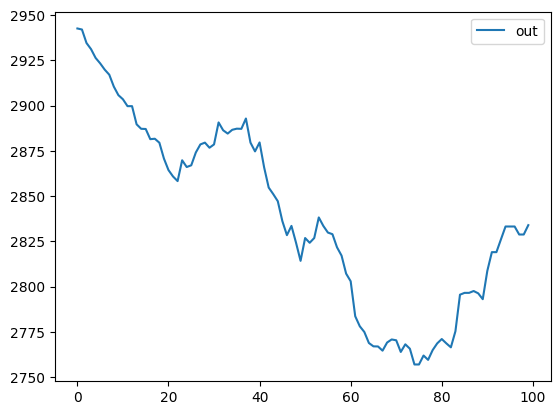

In [36]:
out_df = pd.DataFrame({"out":mse_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

          out
74  36.260036
75  36.260036


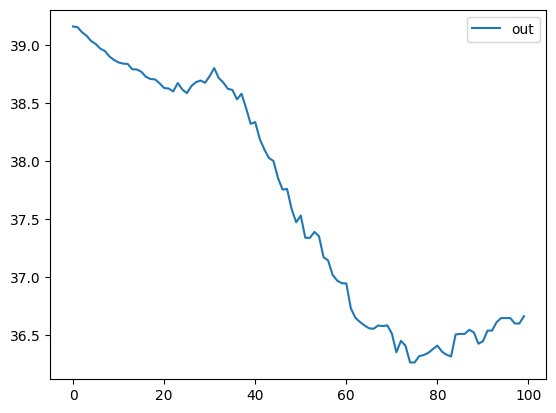

In [37]:
out_df = pd.DataFrame({"out":mae_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

          out
74  13.951416
75  13.951416


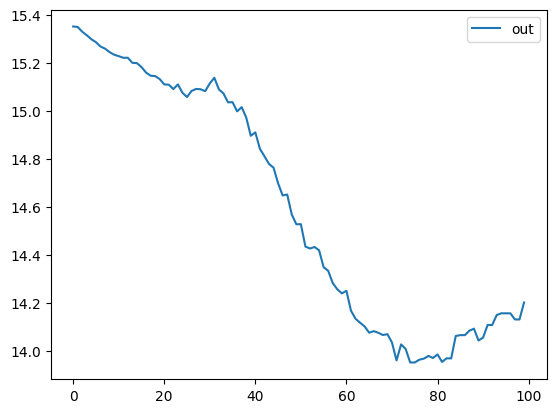

In [38]:
out_df = pd.DataFrame({"out":smape_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

          out
74  52.506626
75  52.506626


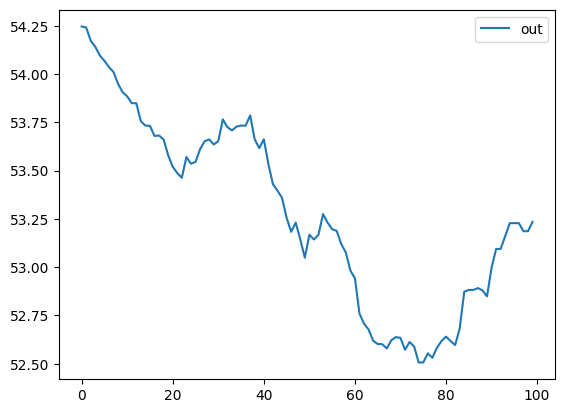

In [39]:
out_df = pd.DataFrame({"out":rmse_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [40]:
attr_df.describe()

,attr
count,7.200000e+02
mean,-1.973730e-17
std,1.000695e+00
min,-1.505839e+00
25%,-3.529927e-01
50%,-1.052243e-01
75%,1.507794e-01
max,1.902016e+01
